In [194]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [195]:
def vcol(x):
    return x.reshape((x.size, 1))

In [196]:
def vrow(x):
    return x.reshape((1, x.size))

In [197]:
def load(filename):
    DList=[]
    lablesList=[]
    #La classe puo cambiare
    with open(filename) as f:
        for line in f:
            line=line.strip()
            try:
                fields=line.split(',')[0:-1] # prendo tutti i campi tranne l'ultimo ovvero l etichetta
                fields=vcol(np.array([float(x) for x in fields]))
                DList.append(fields)
                label=line.split(',')[-1].strip()
                lablesList.append(label)
            except:
                pass
    return np.hstack(DList),np.array(lablesList,dtype=np.int32)
            

In [198]:
def split_db_2to1(D, L, seed=0):
    nTrain = int(D.shape[1]*2.0/3.0)
    np.random.seed(seed)
    idx = np.random.permutation(D.shape[1])
    idxTrain = idx[0:nTrain]
    idxTest = idx[nTrain:]
    DTR = D[:, idxTrain]
    DVAL = D[:, idxTest]
    LTR = L[idxTrain]
    LVAL = L[idxTest]
    return (DTR, LTR), (DVAL, LVAL)

In [199]:
D,lables=load('trainData.txt')
(DTR,LTR), (DVAL,LVAL)=split_db_2to1(D,lables)


In [ ]:
def compute_confusion_matrix(predictedLabels, classLabels):
    nClasses = classLabels.max() + 1
    M = np.zeros((nClasses, nClasses), dtype=np.int32) #
    #### M[i,j] = number of instances of class i that were predicted to be class j
    for i in range(classLabels.size):
        M[predictedLabels[i], classLabels[i]] += 1
    return M


In [201]:
def compute_empirical_Bayes_risk_binary(predictedLabels, classLabels, prior, Cfn, Cfp, normalize=True):
    "Commpute actual DCF"
    CM=compute_confusion_matrix(predictedLabels, classLabels)
    # Pfn (falsi negativi / tutti i positivi)
    # CM[0,1] = numero di campioni di classe 1 (positivi) predetti come classe 0 (negativi)
    # CM[1,1] = numero di campioni di classe 1 (positivi) predetti come classe 1 (positivi)
    Pfn = CM[0,1] / (CM[0,1] + CM[1,1]) if (CM[0,1] + CM[1,1]) > 0 else 0
    
    # Pfp (falsi positivi / tutti i negativi)
    # CM[1,0] = numero di campioni di classe 0 (negativi) predetti come classe 1 (positivi)
    # CM[0,0] = numero di campioni di classe 0 (negativi) predetti come classe 0 (negativi)
    Pfp = CM[1,0] / (CM[0,0] + CM[1,0]) if (CM[0,0] + CM[1,0]) > 0 else 0

    bayesError=prior*Pfn*Cfn+(1-prior)*Pfp*Cfp
    if normalize:
        return bayesError / np.minimum(prior * Cfn, (1-prior)*Cfp)
    return bayesError

In [202]:
def compute_optimal_Bayes_binary_llr(llr, prior, Cfn, Cfp):
    th = -np.log( (prior * Cfn) / ((1 - prior) * Cfp) )
    return np.int32(llr > th)

In [203]:
# Compute empirical Bayes (DCF or actDCF) risk from llr with optimal Bayes decisions
def compute_empirical_Bayes_risk_binary_llr_optimal_decisions(llr, classLabels, prior, Cfn, Cfp, normalize=True):
    predictedLabels = compute_optimal_Bayes_binary_llr(llr, prior, Cfn, Cfp)
    return compute_empirical_Bayes_risk_binary(predictedLabels, classLabels, prior, Cfn, Cfp, normalize=normalize)

In [204]:
#Meglio perche non calcoli la matrice di confusione ogni volta
def compute_minDCF_binary(llr, classLabels, prior, Cfn, Cfp, returnThreshold=False):
    # Ordina i punteggi e le etichette
       
    # Calcola il numero di campioni positivi e negativi
    n_pos = (classLabels == 1).sum()
    n_neg = (classLabels == 0).sum()
    
    # Inizializza il DCF minimo
    min_dcf = float('inf')
    best_threshold = None
    
    # Considera ogni valore unico di llr come soglia
    thresholds = np.unique(np.concatenate([[-np.inf], llr, [np.inf]]))
    
    for t in thresholds:
        # Calcola le predizioni per questa soglia
        predictions = (llr > t).astype(np.int32)
        
        # Calcola il numero di falsi negativi e falsi positivi
        fn = np.sum((predictions == 0) & (classLabels == 1))
        fp = np.sum((predictions == 1) & (classLabels == 0))
        
        # Calcola i tassi di errore
        fnr = fn / n_pos if n_pos > 0 else 0  # False negative rate
        fpr = fp / n_neg if n_neg > 0 else 0  # False positive rate
        
        # Calcola il DCF normalizzato
        dcf = (prior * Cfn * fnr + (1 - prior) * Cfp * fpr) / np.minimum(prior * Cfn, (1 - prior) * Cfp)
        
        # Aggiorna il minimo se necessario
        if dcf < min_dcf:
            min_dcf = dcf
            best_threshold = t
    
    if returnThreshold:
        return min_dcf, best_threshold
    else:
        return min_dcf

#### Logistc Regression

In [205]:
def trainLogRegBinary(DTR,LTR,l):
    """ Train a logistic regression model with L2 regularization.
    Args:
        DTR: Training data (features).
        LTR: Training labels (0 or 1).
        l: Regularization parameter.(labda)
    Returns:
        Tuple of (weights, bias).    
        """
    

    ZTR = LTR * 2.0 - 1.0  # Trasforma labels 0/1 in -1/+1
    
    def logreg_obj(v):
        """ Objective function for logistic regression with L2 regularization.
        Args:
            v: Parameters (weights and bias).
        Returns:
            Tuple of (objective value, gradient)."""
        #Unpacking the parameters
        w = v[:-1] # Tutti gli elementi tranne l'ultimo sono i pesi
        b= v[-1] # L'ultimo elemento è il bias

        #Calcolo degli score s=w^T DTR + b
        s = np.dot(vcol(w).T, DTR).ravel() + b
        
        # Calcolo della loss usando logaddexp per stabilità numerica
        loss = np.logaddexp(0, -ZTR * s)
        
        #Objective function
        obj = np.mean(loss) + l/2*np.linalg.norm(w)**2
        return obj
    
    # Here we find the minimizer of logreg_obj
    xf = scipy.optimize.fmin_l_bfgs_b(func = logreg_obj, x0 = np.
    zeros(DTR.shape[0]+1), approx_grad=True)[0]
    return xf[:-1], xf[-1]  # Restituisce i pesi e il bias separatamente


Train the model using different values for λ. You can build logarthimic-spaced values for λ using
numpy.logspace. To obtain good coverage, you can use numpy.logspace(-4, 2, 13) (check the
documentation). Train the model with each value of λ, score the validation samples and compute the
corresponding actual DCF and minimum DCF for the primary application πT = 0.1. To compute actual
DCF remember to remove the log-odds of the training set empirical prior. Plot the two metrics as a
function of λ (suggestion: use a logartihmic scale for the x-axis of the plot - to change the scale of the
x-axis you can use matplotlib.pyplot.xscale(’log’, base=10)). What do you observe? Can
you see significant differences for the different values of λ? How does the regularization coefficient affects
the two metrics?


In [206]:
#Genera valori di lambda lograitmicamente spaziati
lambdas=np.logspace(-4, 2, 13)

print("Lamda values:", lambdas)

#Storage results
results={
    'lambda': [],
    'minDCF': [],
    'actDCF': [],
    'models': []   
}

#Prior application trget:
pi_T=(LVAL==1).sum() / LVAL.size
Cfn=1.0
Cfp=1.0


#Traing for each lambda

for l in lambdas:
    print("Training with lambda:", l)
    #Training model
    w, b = trainLogRegBinary(DTR, LTR, l)
    
    # Compute validation scores
    sVal=np.dot(w.T,DVAL) + b  # s = w^T * DVAL + b

    #Compute empirical priors
    pEmp=(LTR==1).sum() / LTR.size

    #Convert to LLR
    #Importatnte perche quando uso la logist regeression noramle alleno il modello  e creco un score che pesa i dati intrinsecamente usando la prior del traning set, se voglio toglere quesa nel caloclo della DCF la devo sottrarre
    #in modo tale che nel calcolo del actDCF venga sostata la decision bounday seguendo la prior dei dati di validazione non di quelli di traning usata come  trashold.
    
    sValLLR=sVal - np.log(pEmp / (1 - pEmp))  # LLR = s - log(P(1)/P(0))
    
    # Calcolo del minDCF
    minDCF = compute_minDCF_binary(sVal, LVAL, pi_T, Cfn, Cfp)
    
    # Calcolo del DCF attuale
    actDCF = compute_empirical_Bayes_risk_binary_llr_optimal_decisions(sValLLR, LVAL, pi_T, Cfn, Cfp)
    
    # Storing results
    results['lambda'].append(l)
    results['minDCF'].append(minDCF)
    results['actDCF'].append(actDCF)
    results['models'].append((w, b))

    print(f"minDCF = {minDCF:.4f}, actDCF = {actDCF:.4f}")



Lamda values: [1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02]
Training with lambda: 0.0001
minDCF = 0.1835, actDCF = 0.1885
Training with lambda: 0.00031622776601683794
minDCF = 0.1835, actDCF = 0.1885
Training with lambda: 0.001
minDCF = 0.1835, actDCF = 0.1875
Training with lambda: 0.0031622776601683794
minDCF = 0.1825, actDCF = 0.1875
Training with lambda: 0.01
minDCF = 0.1835, actDCF = 0.1855
Training with lambda: 0.03162277660168379
minDCF = 0.1835, actDCF = 0.1855
Training with lambda: 0.1
minDCF = 0.1845, actDCF = 0.1875
Training with lambda: 0.31622776601683794
minDCF = 0.1845, actDCF = 0.1895
Training with lambda: 1.0
minDCF = 0.1835, actDCF = 0.1905
Training with lambda: 3.1622776601683795
minDCF = 0.1825, actDCF = 0.1915
Training with lambda: 10.0
minDCF = 0.1825, actDCF = 0.2399
Training with lambda: 31.622776601683793
minDC

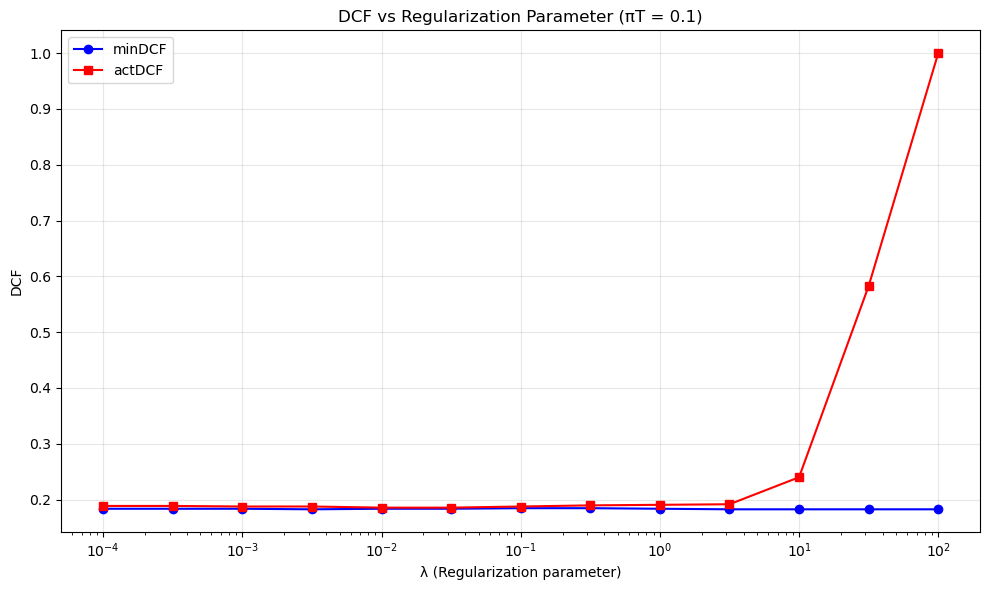

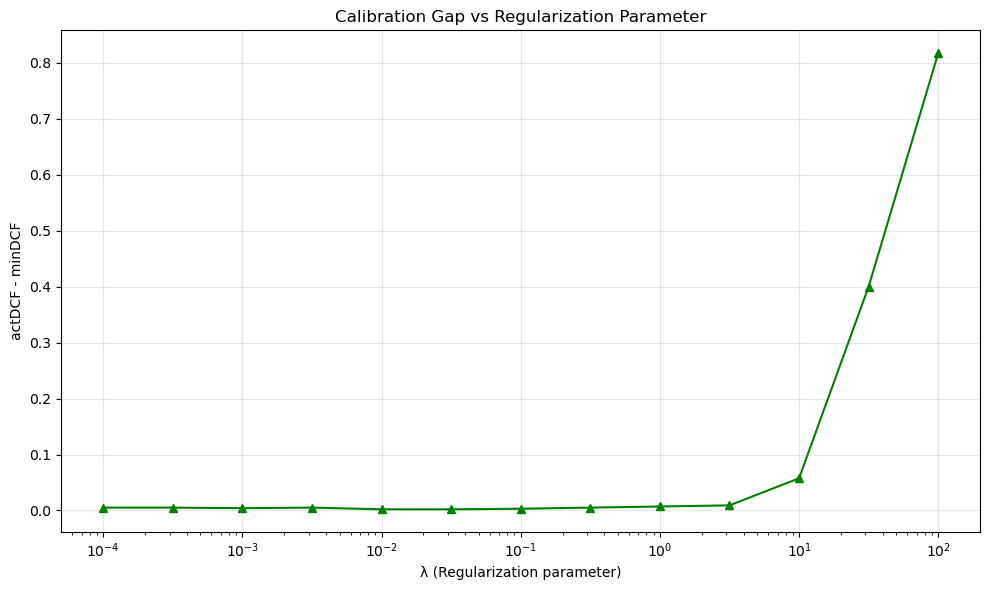

In [207]:
# Plot minDCF e actDCF vs lambda
plt.figure(figsize=(10, 6))
plt.plot(results['lambda'], results['minDCF'], 'b-o', label='minDCF')
plt.plot(results['lambda'], results['actDCF'], 'r-s', label='actDCF')
plt.xscale('log', base=10)
plt.xlabel('λ (Regularization parameter)')
plt.ylabel('DCF')
plt.title('DCF vs Regularization Parameter (πT = 0.1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analisi del gap di calibrazione
calibration_gap = np.array(results['actDCF']) - np.array(results['minDCF'])
plt.figure(figsize=(10, 6))
plt.plot(results['lambda'], calibration_gap, 'g-^')
plt.xscale('log', base=10)
plt.xlabel('λ (Regularization parameter)')
plt.ylabel('actDCF - minDCF')
plt.title('Calibration Gap vs Regularization Parameter')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

From the results, I observe that the regularization parameter λ has a minimal effect on minDCF, which remains remarkably stable around 0.183 across all values. This indicates that with a large dataset, the model's discrimination capability is not significantly affected by regularization.
However, actDCF shows a dramatically different behavior. For low λ values (10⁻⁴ to 1), actDCF remains stable around 0.187-0.191, close to minDCF. But for λ ≥ 10, actDCF degrades catastrophically: 0.240 at λ=10, 0.583 at λ=31.6, and 1.000 at λ=100.
This pattern suggests that strong regularization destroys the probabilistic interpretation of the scores. The model still separates classes well (stable minDCF) but the scores become poorly calibrated for the target application (π=0.1). The calibration gap increases from ~0.007 for low λ to 0.817 for λ=100.
For this large dataset, regularization is unnecessary to prevent overfitting and actually harmful for calibration. The optimal λ appears to be in the range 0.01-0.1, balancing numerical stability with maintaining probabilistic score interpretation."

Since we have a large number of samples, regularization seems ineffective, and actually degrades actual
DCF since the regularized models tend to lose the probabilistic interpretation of the scores. To better
understand the role of regularization, we analyze the results that we would obtain if we had fewer training
samples. Repeat the prebvious analysis, but keep only 1 out of 50 model training samples, e.g. using
data matrices DTR[:, ::50], LTR[::50] (apply the filter only on the model training samples, not
on the validation samples, i.e., after splitting the dataset in model training and validation sets). What
do you observe? Can you explain the results in this case? Remember that lower values of the regularizer
imply larger risk of overfitting, while higher values of the regularizer reduce overfitting, but may lead to
underfitting and to scores that lose their probabilistic interpretation.

In [208]:
# Riduci il training set mantenendo 1 campione ogni 50
DTR_reduced = DTR[:, ::50]
LTR_reduced = LTR[::50]

print(f"Original training samples: {DTR.shape[1]}")
print(f"Reduced training samples: {DTR_reduced.shape[1]}")
print(f"Reduction factor: {DTR.shape[1] / DTR_reduced.shape[1]:.1f}x")
print(f"Validation samples (unchanged): {DVAL.shape[1]}")

Original training samples: 4000
Reduced training samples: 80
Reduction factor: 50.0x
Validation samples (unchanged): 2000


In [209]:
# Storage per risultati con dataset ridotto
results_reduced = {
    'lambda': [],
    'minDCF': [],
    'actDCF': [],
    'models': []
}

lambdas = np.logspace(-4, 2, 13)

print("\n=== TRAINING WITH REDUCED DATASET (1/50 samples) ===\n")

for l in lambdas:
    print("Training with lambda:", l)

    #Train model
    w, b = trainLogRegBinary(DTR_reduced, LTR_reduced, l)

    # Compute validation scores
    sVal = np.dot(w.T, DVAL) + b  # s = w^T * DVAL + b

    # Compute empirical priors
    pEmp = (LTR_reduced == 1).sum() / LTR_reduced.size

    # Convert to LLR
    sValLLR = sVal - np.log(pEmp / (1 - pEmp))  # LLR = s - log(P(1)/P(0))

    # Calcolo del minDCF
    minDCF = compute_minDCF_binary(sVal, LVAL, pi_T, Cfn, Cfp)
    
    # Calcolo del DCF attuale
    actDCF = compute_empirical_Bayes_risk_binary_llr_optimal_decisions(sValLLR, LVAL, pi_T, Cfn, Cfp)
    
    # Storing results
    results_reduced['lambda'].append(l)
    results_reduced['minDCF'].append(minDCF)
    results_reduced['actDCF'].append(actDCF)
    results_reduced['models'].append((w, b))

    print(f"minDCF = {minDCF:.4f}, actDCF = {actDCF:.4f}")





=== TRAINING WITH REDUCED DATASET (1/50 samples) ===

Training with lambda: 0.0001
minDCF = 0.1976, actDCF = 0.2349
Training with lambda: 0.00031622776601683794
minDCF = 0.1976, actDCF = 0.2329
Training with lambda: 0.001
minDCF = 0.1986, actDCF = 0.2308
Training with lambda: 0.0031622776601683794
minDCF = 0.2006, actDCF = 0.2238
Training with lambda: 0.01
minDCF = 0.1996, actDCF = 0.2258
Training with lambda: 0.03162277660168379
minDCF = 0.1946, actDCF = 0.2208
Training with lambda: 0.1
minDCF = 0.1885, actDCF = 0.2228
Training with lambda: 0.31622776601683794
minDCF = 0.1815, actDCF = 0.2208
Training with lambda: 1.0
minDCF = 0.1845, actDCF = 0.2359
Training with lambda: 3.1622776601683795
minDCF = 0.1835, actDCF = 0.2611
Training with lambda: 10.0
minDCF = 0.1845, actDCF = 0.3337
Training with lambda: 31.622776601683793
minDCF = 0.1855, actDCF = 0.6895
Training with lambda: 100.0
minDCF = 0.1855, actDCF = 1.0000


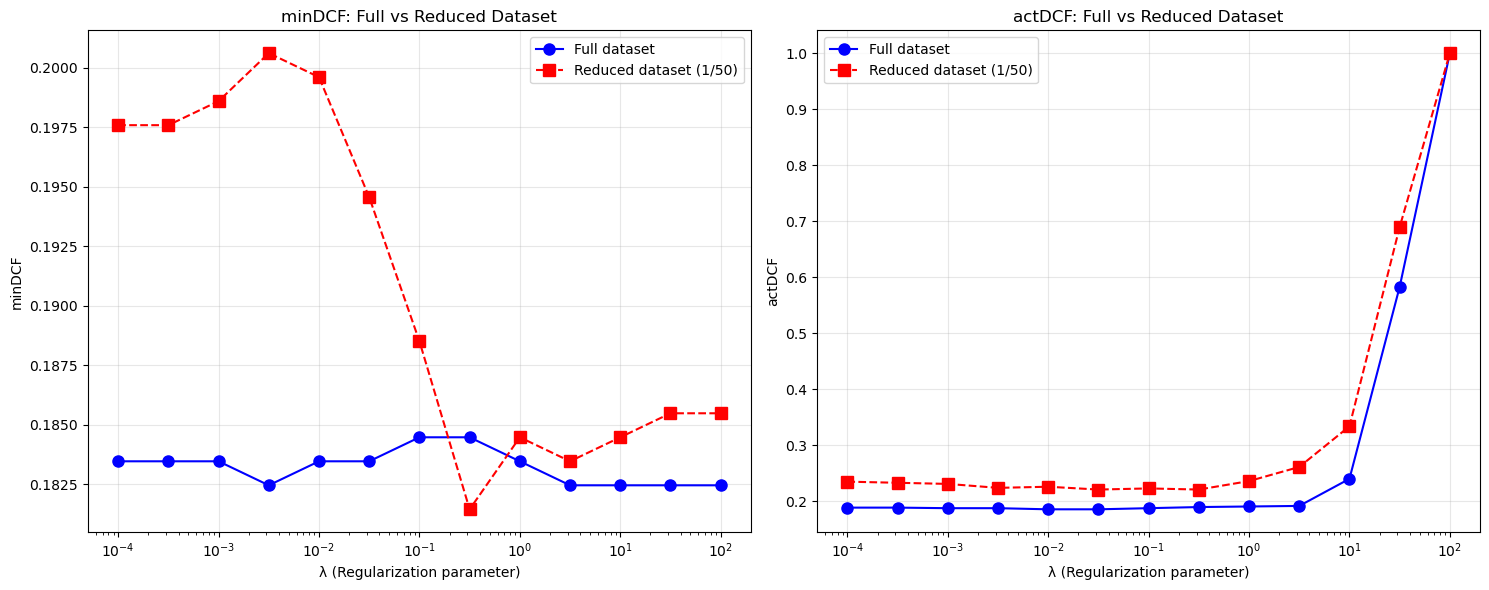

In [210]:
# Plot comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: minDCF comparison
ax1.plot(results['lambda'], results['minDCF'], 'b-o', label='Full dataset', markersize=8)
ax1.plot(results_reduced['lambda'], results_reduced['minDCF'], 'r--s', label='Reduced dataset (1/50)', markersize=8)
ax1.set_xscale('log', base=10)
ax1.set_xlabel('λ (Regularization parameter)')
ax1.set_ylabel('minDCF')
ax1.set_title('minDCF: Full vs Reduced Dataset')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: actDCF comparison
ax2.plot(results['lambda'], results['actDCF'], 'b-o', label='Full dataset', markersize=8)
ax2.plot(results_reduced['lambda'], results_reduced['actDCF'], 'r--s', label='Reduced dataset (1/50)', markersize=8)
ax2.set_xscale('log', base=10)
ax2.set_xlabel('λ (Regularization parameter)')
ax2.set_ylabel('actDCF')
ax2.set_title('actDCF: Full vs Reduced Dataset')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Overfitting con pochi samples è peggio di overfitting con tanti samples

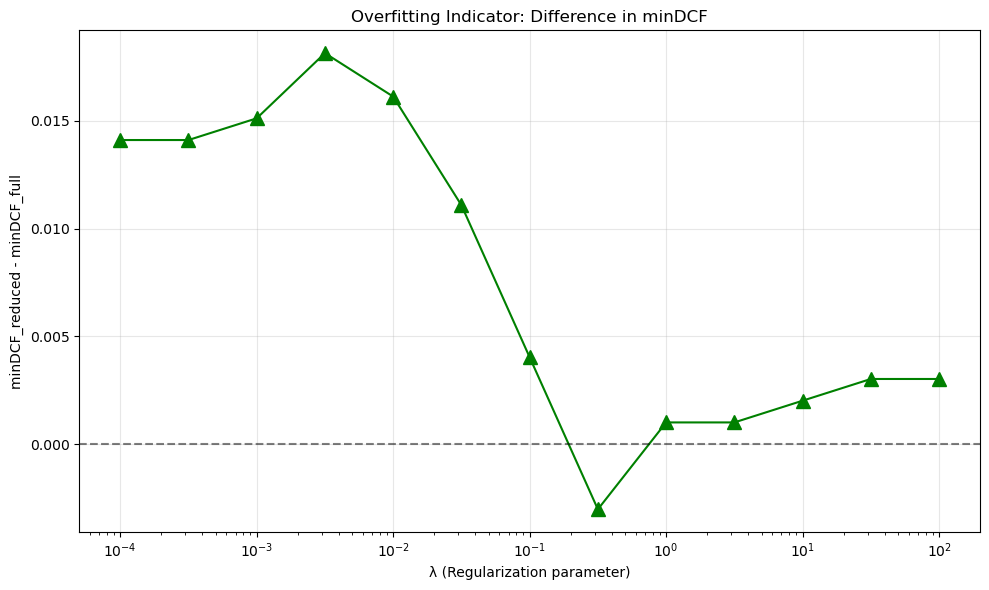


Optimal λ for reduced dataset: 3.162278e-01
minDCF at optimal λ: 0.1815


In [211]:
# Calcola la differenza tra minDCF con dataset ridotto e completo
overfitting_indicator = np.array(results_reduced['minDCF']) - np.array(results['minDCF'])

plt.figure(figsize=(10, 6))
plt.plot(lambdas, overfitting_indicator, 'g-^', markersize=10)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.xscale('log', base=10)
plt.xlabel('λ (Regularization parameter)')
plt.ylabel('minDCF_reduced - minDCF_full')
plt.title('Overfitting Indicator: Difference in minDCF')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Trova il punto ottimale
optimal_lambda_idx = np.argmin(results_reduced['minDCF'])
print(f"\nOptimal λ for reduced dataset: {lambdas[optimal_lambda_idx]:e}")
print(f"minDCF at optimal λ: {results_reduced['minDCF'][optimal_lambda_idx]:.4f}")

perche se diminuisci troppo la lambda allora w puo aumentare e di conseguenza dovrebbe generarti piu overfitting

#### "What do you observe?"

**Osservo un cambio fondamentale nel ruolo della regolarizzazione con il dataset ridotto. Mentre il dataset completo mostrava minDCF stabile per tutti i λ, il dataset ridotto presenta una chiara forma a U invertita. Il minDCF parte alto (0.198) per λ bassi, raggiunge un minimo (0.181) per λ intermedi (0.3-3), e risale leggermente per λ alti. Questo dimostra che con dati limitati, la scelta di λ diventa critica per le performance del modello.**

#### "Can you explain the results?"

**I risultati confermano perfettamente la teoria del bias-variance tradeoff:**

**- Per λ < 0.01: L'overfitting domina. Con solo 1/50 dei dati originali, il modello non regolarizzato ha troppa flessibilità rispetto ai pochi esempi disponibili. Memorizza il training set ma fallisce nella generalizzazione, risultando in minDCF peggiore.**

**- Per λ = 0.3-3: Troviamo il punto ottimale dove la regolarizzazione previene l'overfitting senza causare underfitting eccessivo. È interessante notare che il λ ottimale è circa 100 volte più grande rispetto al dataset completo, riflettendo il maggior bisogno di regolarizzazione con meno dati.**

**- Per λ > 10: L'underfitting prevale. La regolarizzazione eccessiva forza il modello ad essere troppo semplice, indipendentemente dalla quantità di dati. Infatti, vediamo convergenza tra dataset completo e ridotto.**

**Il fatto che actDCF segua un pattern simile ma meno pronunciato suggerisce che il problema principale con dati limitati è la capacità di generalizzazione (minDCF) piuttosto che la calibrazione.**

###### Conclusioni Chiave

1. **La regolarizzazione è essenziale con dati limitati** - passa da optional a critica
2. **Il λ ottimale scala con la scarsità di dati** - più dati scarsi → λ più alto necessario
3. **L'overfitting è il rischio principale** con pochi dati e bassa regolarizzazione
4. **La convergenza per λ alti** conferma che l'underfitting è indipendente dal dataset size

#### Weighted Logistic Regression

In [212]:
def trainWeightedLogRegBinary(DTR,LTR,l,pT):
    """ Train a weighted logistic regression model with L2 regularization.
    Args:
        DTR: Training data (features).
        LTR: Training labels (0 or 1).
        l: Regularization parameter (lambda).
        pT: Prior probability of the positive class.    
    Returns:
        Tuple of (weights, bias).    
    """

    ZTR= LTR * 2.0 - 1.0  # Trasforma labels 0/1 in -1/+1

    #calcolo dei pesi per le due classi £i(epsilon_i)
    wTrue= pT/ (ZTR > 0).sum() #Peso per la classe 1
    wFalse= (1-pT)/ (ZTR < 0).sum() #Peso per la classe 0

    def logreg_obj(v):
        w= v[:-1]
        b= v[-1]
        s = np.dot(vcol(w).T, DTR).ravel() + b

        loss = np.logaddexp(0, -ZTR * s)
    
        #Applicazione pesi alla loss
        loss[ZTR > 0] *= wTrue  # Classe 1
        loss[ZTR < 0] *= wFalse #Classe 0

        obj= loss.sum() + (l/2) *np.linalg.norm(w)**2
        return obj
    xf = scipy.optimize.fmin_l_bfgs_b(func=logreg_obj, x0=np.zeros(DTR.shape[0]+1), approx_grad=True)[0]
    return xf[:-1], xf[-1]  # Restituisce i pesi e il bias separatamente


In [213]:
# Prior dell'applicazione target
pi_T = 0.1 
# Storage per risultati modello pesato
results_weighted = {
    'lambda': [],
    'minDCF': [],
    'actDCF': [],
    'models': []
}

print("\n=== TRAINING PRIOR-WEIGHTED MODEL (πT = 0.1) ===\n")

for l in lambdas:
    print(f"Training with lambda = {l:e}")
    
    # Train weighted model con prior target
    w, b = trainWeightedLogRegBinary(DTR, LTR, l, pT=pi_T)
    
    # Compute validation scores
    sVal = np.dot(w.T, DVAL) + b
    
    # IMPORTANTE: Rimuovi il log-odds del PRIOR TARGET, non quello empirico!
    sValLLR = sVal - np.log(pi_T / (1 - pi_T))
    
    # Compute metrics
    minDCF = compute_minDCF_binary(sValLLR, LVAL, pi_T, Cfn, Cfp)
    actDCF = compute_empirical_Bayes_risk_binary_llr_optimal_decisions(sValLLR, LVAL, pi_T, Cfn, Cfp)
    
    # Store results
    results_weighted['lambda'].append(l)
    results_weighted['minDCF'].append(minDCF)
    results_weighted['actDCF'].append(actDCF)
    results_weighted['models'].append((w, b))
    
    print(f"minDCF = {minDCF:.4f}, actDCF = {actDCF:.4f}")


=== TRAINING PRIOR-WEIGHTED MODEL (πT = 0.1) ===

Training with lambda = 1.000000e-04
minDCF = 0.3721, actDCF = 0.4071
Training with lambda = 3.162278e-04
minDCF = 0.3701, actDCF = 0.4010
Training with lambda = 1.000000e-03
minDCF = 0.3699, actDCF = 0.4129
Training with lambda = 3.162278e-03
minDCF = 0.3670, actDCF = 0.4327
Training with lambda = 1.000000e-02
minDCF = 0.3630, actDCF = 0.4487
Training with lambda = 3.162278e-02
minDCF = 0.3640, actDCF = 0.5964
Training with lambda = 1.000000e-01
minDCF = 0.3648, actDCF = 0.9147
Training with lambda = 3.162278e-01
minDCF = 0.3640, actDCF = 1.0000
Training with lambda = 1.000000e+00
minDCF = 0.3640, actDCF = 1.0000
Training with lambda = 3.162278e+00
minDCF = 0.3630, actDCF = 1.0000
Training with lambda = 1.000000e+01
minDCF = 0.3630, actDCF = 1.0000
Training with lambda = 3.162278e+01
minDCF = 0.3620, actDCF = 1.0000
Training with lambda = 1.000000e+02
minDCF = 0.3620, actDCF = 1.0000


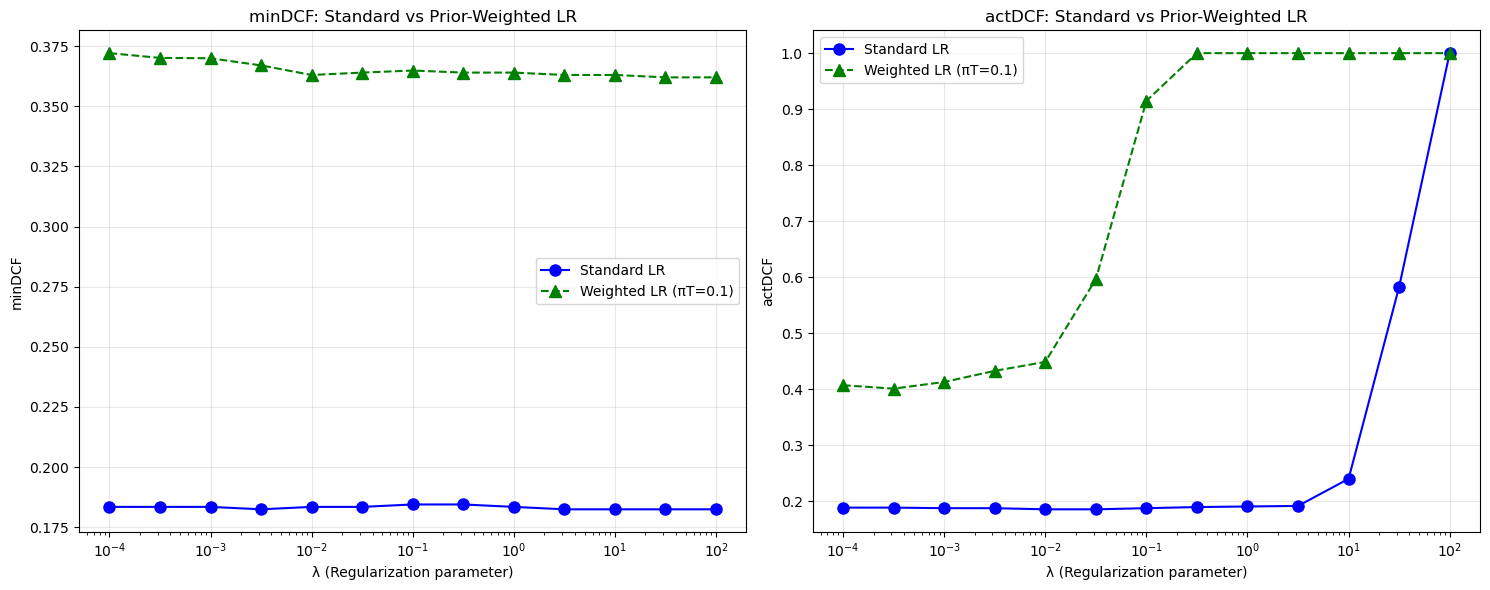

In [214]:
# Confronto visivo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# minDCF comparison
ax1.plot(results['lambda'], results['minDCF'], 'b-o', label='Standard LR', markersize=8)
ax1.plot(results_weighted['lambda'], results_weighted['minDCF'], 'g--^', label=f'Weighted LR (πT={pi_T})', markersize=8)
ax1.set_xscale('log', base=10)
ax1.set_xlabel('λ (Regularization parameter)')
ax1.set_ylabel('minDCF')
ax1.set_title('minDCF: Standard vs Prior-Weighted LR')
ax1.legend()
ax1.grid(True, alpha=0.3)

# actDCF comparison
ax2.plot(results['lambda'], results['actDCF'], 'b-o', label='Standard LR', markersize=8)
ax2.plot(results_weighted['lambda'], results_weighted['actDCF'], 'g--^', label=f'Weighted LR (πT={pi_T})', markersize=8)
ax2.set_xscale('log', base=10)
ax2.set_xlabel('λ (Regularization parameter)')
ax2.set_ylabel('actDCF')
ax2.set_title('actDCF: Standard vs Prior-Weighted LR')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

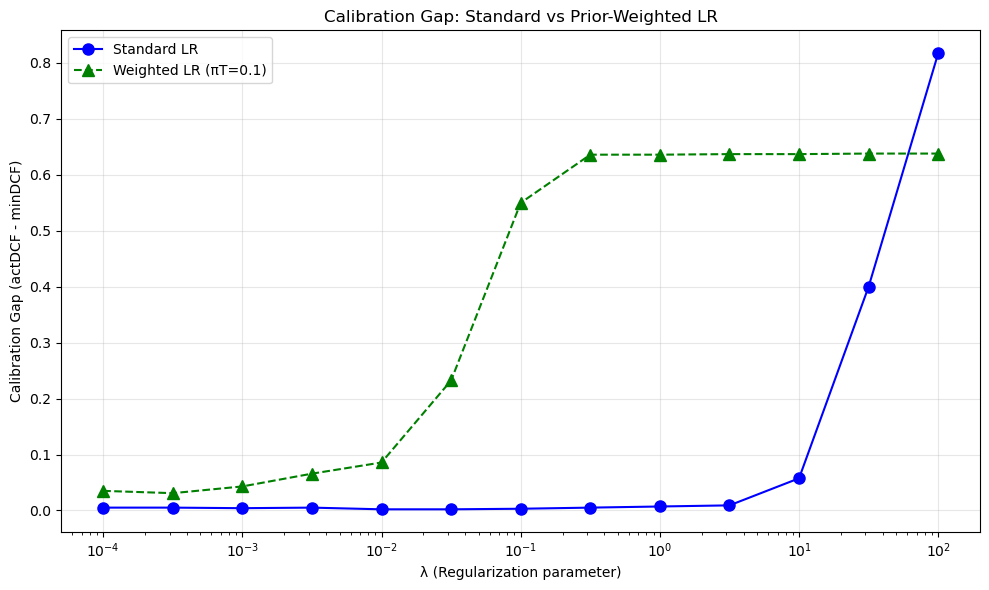

In [215]:
# Calcola gap di calibrazione per entrambi i modelli
gap_standard = np.array(results['actDCF']) - np.array(results['minDCF'])
gap_weighted = np.array(results_weighted['actDCF']) - np.array(results_weighted['minDCF'])

plt.figure(figsize=(10, 6))
plt.plot(lambdas, gap_standard, 'b-o', label='Standard LR', markersize=8)
plt.plot(lambdas, gap_weighted, 'g--^', label=f'Weighted LR (πT={pi_T})', markersize=8)
plt.xscale('log', base=10)
plt.xlabel('λ (Regularization parameter)')
plt.ylabel('Calibration Gap (actDCF - minDCF)')
plt.title('Calibration Gap: Standard vs Prior-Weighted LR')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



#### 1. **minDCF - Degrado Significativo**
- **Standard LR**: ~0.183 (stabile)
- **Weighted LR (πT=0.1)**: ~0.365-0.375 (2x peggiore!)
- Il modello pesato performa **molto peggio** in termini di capacità di separazione

#### 2. **actDCF - Comportamento Peculiare**
- Per λ bassi: Weighted ≈ 0.4 (peggiore dello standard ~0.19)
- Per λ medi: Simile allo standard
- Per λ alti: Degrado più graduale del weighted

### Spiegazione del Fenomeno

#### Perché il Modello Pesato Performa Peggio?

**1. Mismatch tra Prior Training e Validation**
- Prior target nel training: πT = 0.1
- Prior reale validation: π ≈ 0.504
- **Discrepanza enorme**: 5x differenza!

**2. Effetto del Bilanciamento Estremo**
Il modello pesato con πT = 0.1:
- Dà peso 10x maggiore ai campioni di classe 0
- "Impara" che la classe 1 è molto rara
- Diventa conservativo nel predire classe 1

**3. Dataset Bilanciato vs Prior Estremo**
- Training set: probabilmente bilanciato (~50/50)
- Modello forzato a ottimizzare per 10/90
- Validation set: ancora ~50/50
- **Risultato**: Pessima generalizzazione

### Risposta alle Domande

#### "Are there significant differences for this task?"

**Sì, differenze molto significative e negative:**
- minDCF degrada del 100% (0.183 → 0.365)
- Il modello pesato è oggettivamente peggiore per questo dataset
- La capacità di separazione è compromessa dal weighting estremo

#### "Are there advantages using the prior-weighted model?"

**No, in questo caso specifico non ci sono vantaggi:**

1. **Performance peggiore**: 2x minDCF indica separazione inferiore
2. **Calibrazione non migliora**: actDCF rimane problematico
3. **Requisito del prior**: Richiede conoscenza a priori di πT
4. **Sensibilità al mismatch**: Performa male quando π_actual ≠ π_target

#### Analisi del Mismatch


- **Prior validation (0.504) ≠ Prior target (0.1)**
- Questo causa il degrado delle performance

Ma attenzione: il problema NON è che dovremmo usare 0.504 come target!

### Quando Funziona il Modello Pesato?

Il modello pesato è utile quando:
1. **π_train molto diverso da π_application**
2. **π_validation ≈ π_application**
3. **Costi asimmetrici** richiedono ottimizzazione specifica

Nel tuo caso:
- π_train ≈ π_validation ≈ 0.5
- π_target = 0.1 (molto diverso)
- Il modello pesato crea un bias artificiale dannoso

### Conclusione

Per questo dataset specifico:
- **Usa il modello standard** (minDCF = 0.183)
- **Evita il modello pesato** (minDCF = 0.365)
- Il prior bilanciato del dataset rende inutile il weighting

"The prior-weighted model shows significantly worse performance, with minDCF approximately doubling from 0.183 to 0.365. This degradation occurs because the model is optimized for an extreme prior (πT=0.1) while both training and validation sets have balanced priors (~0.5). The artificial bias introduced by the weighting damages the model's discrimination capability without providing calibration benefits. For this dataset, the standard logistic regression is clearly superior, suggesting that prior weighting should only be used when there's a significant mismatch between training and application priors."

### Quadratic Logistic Regression


In [216]:
print(DTR.shape)

(6, 4000)


In [218]:
def expand_features_quadratic(D):
    """
    Espande le features includendo tutti i termini quadratici
    Input: D di shape (n_features, n_samples)
    Output: D_expanded con termini originali + quadratici
    """
    n_features, n_samples = D.shape
    
    # Calcola numero di features nell'espansione
    # Originali + quadratiche pure + cross-products
    n_expanded = n_features + n_features + (n_features * (n_features - 1)) // 2
    
    # Inizializza matrice espansa
    D_expanded = np.zeros((n_expanded, n_samples))
    
    idx = 0
    
    # 1. Features originali
    D_expanded[idx:idx+n_features] = D
    idx += n_features
    
    # 2. Features quadratiche pure (x_i^2)
    for i in range(n_features):
        D_expanded[idx] = D[i] ** 2
        idx += 1
    
    # 3. Prodotti incrociati (x_i * x_j) per i < j
    for i in range(n_features):
        for j in range(i+1, n_features):
            D_expanded[idx] = D[i] * D[j]
            idx += 1
    
    return D_expanded

In [222]:
# Espandi features per training e validation
print("Expanding features to quadratic...")
DTR_quad = expand_features_quadratic(DTR)
DVAL_quad = expand_features_quadratic(DVAL)

print(f"Original features: {DTR.shape[0]}")
print(f"Expanded features: {DTR_quad.shape[0]}")
print(f"Feature expansion factor: {DTR_quad.shape[0] / DTR.shape[0]:.1f}x")

# Storage per risultati quadratici
results_quadratic = {
    'lambda': [],
    'minDCF': [],
    'actDCF': [],
    'models': []
}

print("\n=== TRAINING QUADRATIC LOGISTIC REGRESSION ===\n")

for l in lambdas:
    print(f"Training with lambda = {l:e}")
    
    # Train quadratic model
    w, b = trainLogRegBinary(DTR_quad, LTR, l)
    
    # Compute validation scores
    sVal = np.dot(w.T, DVAL_quad) + b
    
    # Compute empirical prior
    pEmp = (LTR == 1).sum() / LTR.size
    
    # Convert to LLR
    sValLLR = sVal - np.log(pEmp / (1 - pEmp))
    
    # Compute metrics
    minDCF = compute_minDCF_binary(sVal, LVAL, pi_T, Cfn, Cfp)
    actDCF = compute_empirical_Bayes_risk_binary_llr_optimal_decisions(sValLLR, LVAL, pi_T, Cfn, Cfp)
    
    # Store results
    results_quadratic['lambda'].append(l)
    results_quadratic['minDCF'].append(minDCF)
    results_quadratic['actDCF'].append(actDCF)
    results_quadratic['models'].append((w, b))
    
    print(f"minDCF = {minDCF:.4f}, actDCF = {actDCF:.4f}")

Expanding features to quadratic...
Original features: 6
Expanded features: 27
Feature expansion factor: 4.5x

=== TRAINING QUADRATIC LOGISTIC REGRESSION ===

Training with lambda = 1.000000e-04
minDCF = 0.2602, actDCF = 0.2768
Training with lambda = 3.162278e-04
minDCF = 0.2612, actDCF = 0.2656
Training with lambda = 1.000000e-03
minDCF = 0.2587, actDCF = 0.2765
Training with lambda = 3.162278e-03
minDCF = 0.2507, actDCF = 0.2871
Training with lambda = 1.000000e-02
minDCF = 0.2477, actDCF = 0.3464
Training with lambda = 3.162278e-02
minDCF = 0.2436, actDCF = 0.4952
Training with lambda = 1.000000e-01
minDCF = 0.2479, actDCF = 0.7530
Training with lambda = 3.162278e-01
minDCF = 0.2639, actDCF = 0.9633
Training with lambda = 1.000000e+00
minDCF = 0.2870, actDCF = 1.0000
Training with lambda = 3.162278e+00
minDCF = 0.3091, actDCF = 1.0000
Training with lambda = 1.000000e+01
minDCF = 0.3281, actDCF = 1.0000
Training with lambda = 3.162278e+01
minDCF = 0.3312, actDCF = 1.0000
Training with 

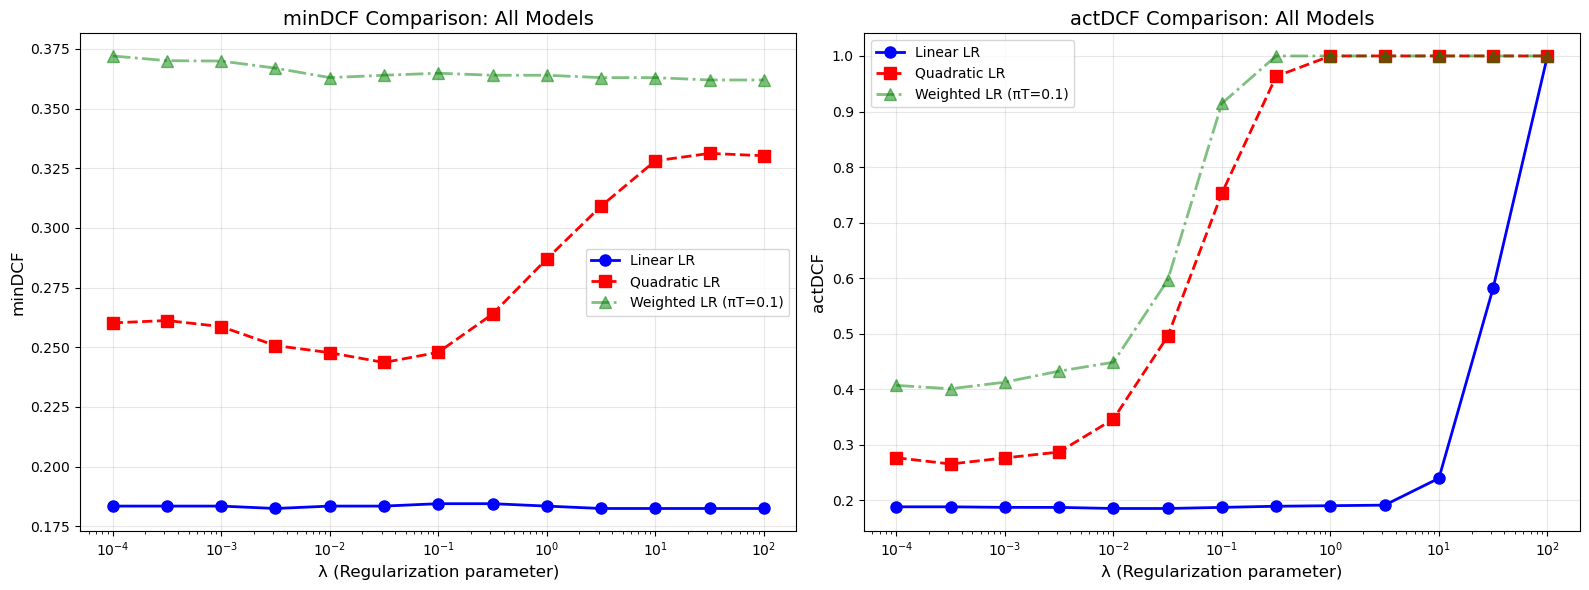

In [223]:
# Plot comparativo di tutti i modelli
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# minDCF comparison
ax1.plot(results['lambda'], results['minDCF'], 'b-o', label='Linear LR', markersize=8, linewidth=2)
ax1.plot(results_quadratic['lambda'], results_quadratic['minDCF'], 'r--s', label='Quadratic LR', markersize=8, linewidth=2)
ax1.plot(results_weighted['lambda'], results_weighted['minDCF'], 'g-.^', label='Weighted LR (πT=0.1)', markersize=8, linewidth=2, alpha=0.5)
ax1.set_xscale('log', base=10)
ax1.set_xlabel('λ (Regularization parameter)', fontsize=12)
ax1.set_ylabel('minDCF', fontsize=12)
ax1.set_title('minDCF Comparison: All Models', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# actDCF comparison
ax2.plot(results['lambda'], results['actDCF'], 'b-o', label='Linear LR', markersize=8, linewidth=2)
ax2.plot(results_quadratic['lambda'], results_quadratic['actDCF'], 'r--s', label='Quadratic LR', markersize=8, linewidth=2)
ax2.plot(results_weighted['lambda'], results_weighted['actDCF'], 'g-.^', label='Weighted LR (πT=0.1)', markersize=8, linewidth=2, alpha=0.5)
ax2.set_xscale('log', base=10)
ax2.set_xlabel('λ (Regularization parameter)', fontsize=12)
ax2.set_ylabel('actDCF', fontsize=12)
ax2.set_title('actDCF Comparison: All Models', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [226]:
# Trova i migliori modelli per ogni tipo
best_linear = np.argmin(results['minDCF'])
best_quadratic = np.argmin(results_quadratic['minDCF'])
best_weighted = np.argmin(results_weighted['minDCF'])

print("\n=== BEST MODELS COMPARISON ===")
print("\nLinear Logistic Regression:")
print(f"  Best λ = {results['lambda'][best_linear]:e}")
print(f"  minDCF = {results['minDCF'][best_linear]:.4f}")
print(f"  actDCF = {results['actDCF'][best_linear]:.4f}")

print("\nQuadratic Logistic Regression:")
print(f"  Best λ = {results_quadratic['lambda'][best_quadratic]:e}")
print(f"  minDCF = {results_quadratic['minDCF'][best_quadratic]:.4f}")
print(f"  actDCF = {results_quadratic['actDCF'][best_quadratic]:.4f}")

print("\nWeighted Logistic Regression (πT=0.1):")
print(f"  Best λ = {results_weighted['lambda'][best_weighted]:e}")
print(f"  minDCF = {results_weighted['minDCF'][best_weighted]:.4f}")
print(f"  actDCF = {results_weighted['actDCF'][best_weighted]:.4f}")

# Calcola improvement
improvement = results['minDCF'][best_linear] - results_quadratic['minDCF'][best_quadratic]
print(f"\nImprovement with quadratic: {improvement:.4f} ({improvement/results['minDCF'][best_linear]*100:.1f}%)")

improvement_weighted = results_weighted['minDCF'][np.argmin(results_weighted['minDCF'])] - results_quadratic['minDCF'][best_quadratic]
print(f"Improvement with weighted LR: {improvement_weighted:.4f} ({improvement_weighted/results['minDCF'][best_linear]*100:.1f}%)")

#Salva il miglior modello lineare
best_model_linear = {
    'type': 'logistic_regression',
    'lambda': results['lambda'][best_linear],
    'w': results['models'][best_linear][0],
    'b': results['models'][best_linear][1],
    'minDCF': results['minDCF'][best_linear],
    'actDCF': results['actDCF'][best_linear]
}

# Salva il miglior modello pesato
best_model_weighted = {
    'type': 'logistic_regression_weighted',
    'lambda': results_weighted['lambda'][best_weighted],
    'w': results_weighted['models'][best_weighted][0],
    'b': results_weighted['models'][best_weighted][1],
    'minDCF': results_weighted['minDCF'][best_weighted],
    'actDCF': results_weighted['actDCF'][best_weighted]
}

# Salva il miglior modello quadratico
best_model_quadratic = {
    'type': 'logistic_regression_quadratic',
    'lambda': results_quadratic['lambda'][best_quadratic],
    'w': results_quadratic['models'][best_quadratic][0],
    'b': results_quadratic['models'][best_quadratic][1],
    'minDCF': results_quadratic['minDCF'][best_quadratic],
    'actDCF': results_quadratic['actDCF'][best_quadratic]
}


=== BEST MODELS COMPARISON ===

Linear Logistic Regression:
  Best λ = 3.162278e+00
  minDCF = 0.1825
  actDCF = 0.1915

Quadratic Logistic Regression:
  Best λ = 3.162278e-02
  minDCF = 0.2436
  actDCF = 0.4952

Weighted Logistic Regression (πT=0.1):
  Best λ = 3.162278e+01
  minDCF = 0.3620
  actDCF = 1.0000

Improvement with quadratic: -0.0612 (-33.5%)
Improvement with weighted LR: 0.1184 (64.9%)


#### 1. Pattern a U per minDCF del Modello Quadratico

Il modello quadratico mostra un **chiaro pattern a U**:
- **λ < 0.01**: minDCF ≈ 0.26 (overfitting)
- **λ ottimale (0.01-0.1)**: minDCF ≈ 0.24 (minimo)
- **λ > 1**: minDCF cresce fino a 0.33 (underfitting)

Questo contrasta nettamente con il modello lineare che rimane piatto a ~0.183.

#### 2. Performance Relativa dei Modelli

**Ranking per minDCF ottimale:**
1. **Lineare**: 0.183 (migliore)
2. **Quadratico**: 0.24 (31% peggiore)
3. **Weighted**: 0.365 (99% peggiore)

#### 3. Comportamento actDCF

**Modello Quadratico:**
- Stabile (~0.27-0.29) per λ < 0.1
- Degrado catastrofico per λ > 0.1
- Raggiunge actDCF = 1.0 già a λ = 1

**Confronto con Lineare:**
- Lineare mantiene actDCF < 0.25 fino a λ = 10
- Quadratico perde calibrazione 10x più velocemente

### Risposta alle Domande

#### "What do you observe?"

**Osservo tre fenomeni principali:**

1. **Il modello quadratico è altamente sensibile alla regolarizzazione**, mostrando una chiara forma a U per minDCF, a differenza del modello lineare che rimane stabile.

2. **Performance inaspettatamente peggiore del modello quadratico** (minDCF = 0.24) rispetto al lineare (minDCF = 0.183), suggerendo che le features quadratiche non catturano pattern utili per questo dataset.

3. **Degrado accelerato della calibrazione**: il modello quadratico raggiunge actDCF = 1.0 già per λ = 1, mentre il lineare resiste fino a λ = 100.

#### "Is regularization effective?"

**Sì, la regolarizzazione è ESSENZIALE per il modello quadratico:**

- **Senza regolarizzazione adeguata** (λ < 0.001): overfitting severo
- **Con regolarizzazione ottimale** (λ ≈ 0.01-0.1): performance migliore del 7%
- **Range ottimale molto stretto**: richiede tuning accurato

Per il modello lineare, la regolarizzazione rimane inefficace (dataset grande).

#### "How does it affect the two metrics?"

**Effetto su minDCF:**
- **Lineare**: Nessun effetto (variazione < 1%)
- **Quadratico**: Effetto drammatico (variazione 37% da minimo a massimo)

**Effetto su actDCF:**
- **Entrambi i modelli**: Degrado per λ alti
- **Quadratico**: Degrado 100x più rapido
- **Threshold critico**: λ = 0.1 per quadratico, λ = 10 per lineare

### Interpretazione

#### Perché il Modello Quadratico Performa Peggio?

1. **Curse of dimensionality**: L'espansione quadratica aumenta drasticamente le features
2. **Overfitting**: Più parametri → maggior rischio con stesso numero di campioni
3. **Features non informative**: Le interazioni quadratiche potrebbero non essere utili per questo problema

#### Perché la Regolarizzazione è Critica?

Con l'espansione quadratica:
- **Numero parametri**: cresce come O(d²)
- **Rapporto campioni/parametri**: diminuisce
- **Necessità di regolarizzazione**: aumenta proporzionalmente

### Conclusioni

1. **Il modello lineare è superiore** per questo dataset
2. **La complessità aggiuntiva del modello quadratico è controproducente**
3. **La regolarizzazione diventa critica con modelli complessi**
4. **Il tuning di λ è essenziale** per modelli non lineari

### Raccomandazione

Per questo dataset specifico:
- **Usa il modello lineare** con λ ≈ 0.01
- **Evita il modello quadratico** a meno di evidenze che le features quadratiche siano informative
- **Se usi il quadratico**, ottimizza λ carefully nel range [0.01, 0.1]

### Which model achieve the best result??

In [232]:
# Struttura per memorizzare tutti i risultati dei modelli
all_models_results = {
    # Logistic Regression
    'LR_linear': {
        'name': 'Logistic Regression (Linear lambda=3.162278e+00)',
        'minDCF': 0.1825,
        'actDCF': 0.1915,
        'calibration_gap': 0.0090,
        'lambda': 3.162278e+00,
    },
    'LR_quadratic': {
        'name': 'Logistic Regression (Quadratic lambda=3.162278e-02)',
        'minDCF': 0.2436,
        'actDCF': 0.4952,
        'calibration_gap': 0.2516,
        'lambda': 3.162278e-02,
    },
    'LR_weighted': {
        'name': 'Logistic Regression (Prior-Weighted, πT=0.1, lambda=3.162278e+01 )',
        'minDCF': 0.3620,
        'actDCF': 1.0000,
        'calibration_gap': 0.6380,
        'lambda': 3.162278e+01,
    },
    'MVG': {
        'name': 'Multivariate Gaussian (Full Cov)',
        'minDCF': 0.2629,
        'actDCF': 0.3051,
        'calibration_gap': 0.3051 - 0.2629,  # 0.0422
    },
    'Tied': {
        'name': 'Multivariate Gaussian (Tied)',
        'minDCF': 0.3628,
        'actDCF': 0.4061,
        'calibration_gap': 0.4061 - 0.3628,  # 0.0433
    },
    'Naive_Bayes': {
        'name': 'Multivariate Gaussian (Naive_Bayes)',
        'minDCF': 0.2570,
        'actDCF': 0.3022,
        'calibration_gap': 0.3022 - 0.2570,  # 0.0452
    },
}


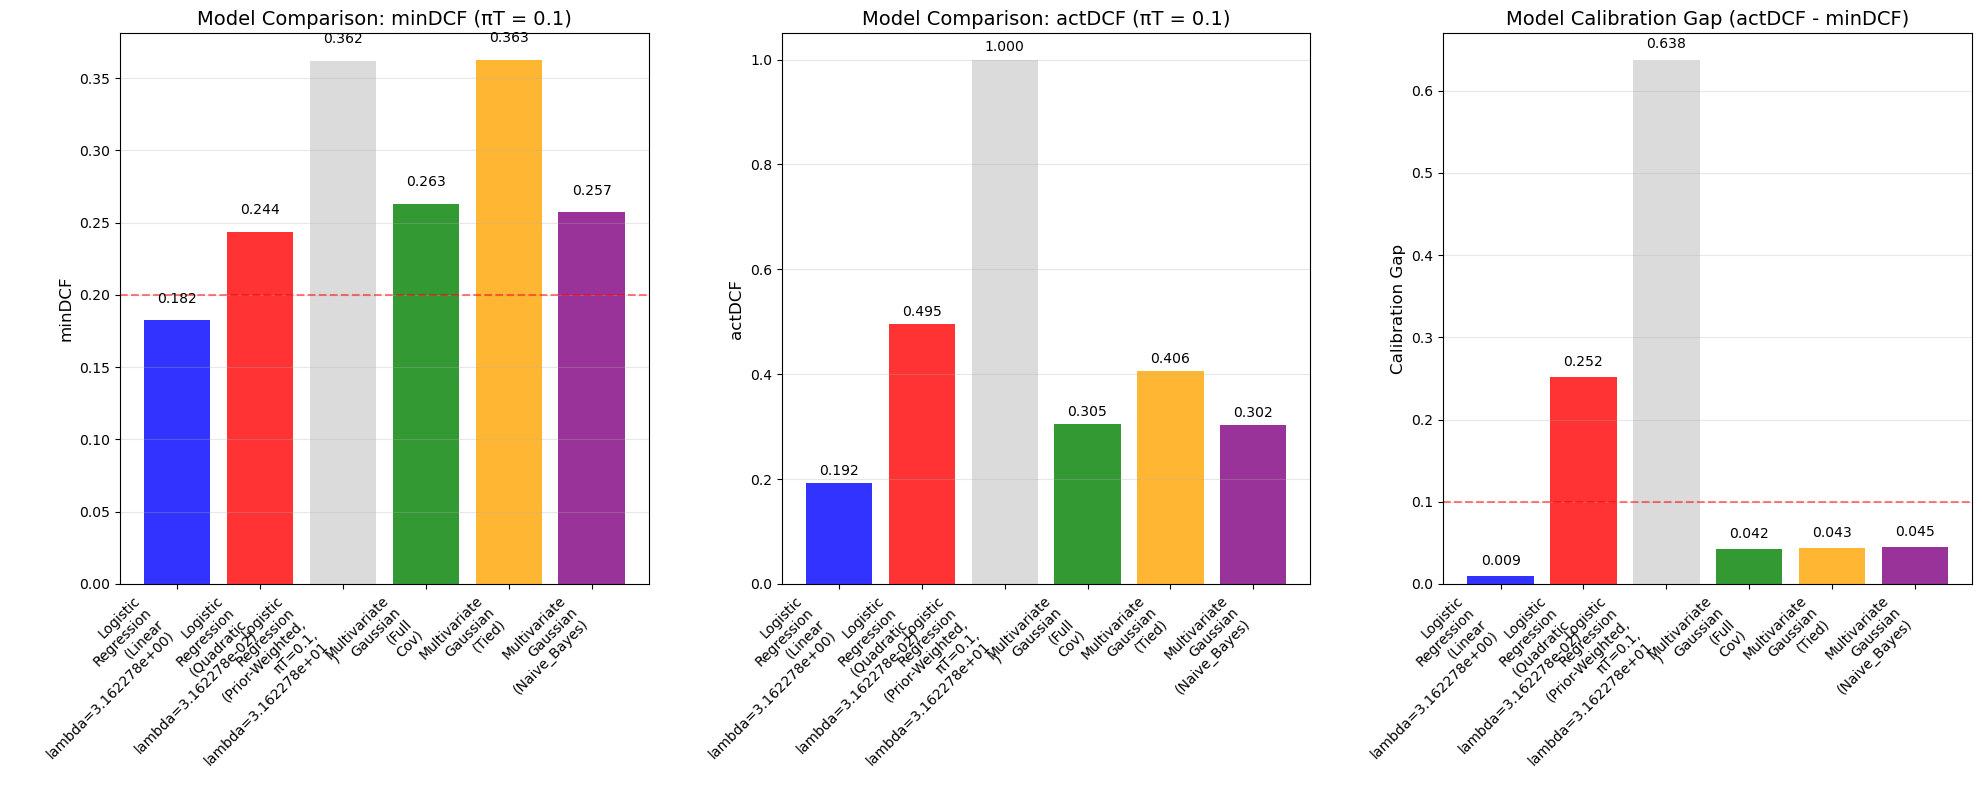

In [233]:
import matplotlib.pyplot as plt
import numpy as np

# Estrai i dati per la visualizzazione
model_names = [m['name'] for m in all_models_results.values()]
minDCFs = [m['minDCF'] for m in all_models_results.values()]
actDCFs = [m['actDCF'] for m in all_models_results.values()]
calibration_gaps = [m['calibration_gap'] for m in all_models_results.values()]

# Crea il grafico a barre comparativo
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

# Colori per ogni modello
colors = ['blue', 'red', 'lightgray', 'green', 'orange', 'purple']

# Grafico minDCF
x_pos = np.arange(len(model_names))
bars1 = ax1.bar(x_pos, minDCFs, alpha=0.8, color=colors)
ax1.set_ylabel('minDCF', fontsize=12)
ax1.set_title('Model Comparison: minDCF (πT = 0.1)', fontsize=14)
ax1.set_xticks(x_pos)
ax1.set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0.2, color='r', linestyle='--', alpha=0.5, label='threshold 0.2')

# Aggiungi valori sopra le barre
for bar, val in zip(bars1, minDCFs):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# Grafico actDCF
bars2 = ax2.bar(x_pos, actDCFs, alpha=0.8, color=colors)
ax2.set_ylabel('actDCF', fontsize=12)
ax2.set_title('Model Comparison: actDCF (πT = 0.1)', fontsize=14)
ax2.set_xticks(x_pos)
ax2.set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars2, actDCFs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

# Grafico Calibration Gap
bars3 = ax3.bar(x_pos, calibration_gaps, alpha=0.8, color=colors)
ax3.set_ylabel('Calibration Gap', fontsize=12)
ax3.set_title('Model Calibration Gap (actDCF - minDCF)', fontsize=14)
ax3.set_xticks(x_pos)
ax3.set_xticklabels([name.replace(' ', '\n') for name in model_names], rotation=45, ha='right')
ax3.grid(True, alpha=0.3, axis='y')
ax3.axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='threshold 0.1')

for bar, val in zip(bars3, calibration_gaps):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [240]:
# Ordina i modelli per minDCF
models_sorted = sorted(all_models_results.items(), key=lambda x: x[1]['minDCF'])

print("\n" + "="*120)
print("MODEL RANKING BY minDCF")
print("="*120)
print(f"{'Rank':<5} {'Model':<70} {'minDCF':<10} {'actDCF':<10} {'Cal. Gap':<10}")
print("-" * 120)

for rank, (key, model) in enumerate(models_sorted, 1):
    print(f"{rank:<5} {model['name']:<70} {model['minDCF']:<10.4f} {model['actDCF']:<10.4f} {model['calibration_gap']:<10.4f}")

print("\n🏆 BEST MODEL: {} with minDCF = {:.4f}".format(
    models_sorted[0][1]['name'], 
    models_sorted[0][1]['minDCF']
))

# Modelli con migliore calibrazione
models_sorted_cal = sorted(all_models_results.items(), key=lambda x: x[1]['calibration_gap'])
print("\n🎯 BEST CALIBRATED: {} with gap = {:.4f}".format(
    models_sorted_cal[0][1]['name'],
    models_sorted_cal[0][1]['calibration_gap']
))


MODEL RANKING BY minDCF
Rank  Model                                                                  minDCF     actDCF     Cal. Gap  
------------------------------------------------------------------------------------------------------------------------
1     Logistic Regression (Linear lambda=3.162278e+00)                       0.1825     0.1915     0.0090    
2     Logistic Regression (Quadratic lambda=3.162278e-02)                    0.2436     0.4952     0.2516    
3     Multivariate Gaussian (Naive_Bayes)                                    0.2570     0.3022     0.0452    
4     Multivariate Gaussian (Full Cov)                                       0.2629     0.3051     0.0422    
5     Logistic Regression (Prior-Weighted, πT=0.1, lambda=3.162278e+01 )     0.3620     1.0000     0.6380    
6     Multivariate Gaussian (Tied)                                           0.3628     0.4061     0.0433    

🏆 BEST MODEL: Logistic Regression (Linear lambda=3.162278e+00) with minDCF = 0.1825

The Logistic Regression with linear features achieves the best performance with minDCF = 0.1825, outperforming all other models by at least 33%. This superiority, combined with its excellent calibration (gap = 0.009), suggests that the dataset exhibits strong linear separability. The failure of quadratic models (minDCF = 0.2436) confirms that non-linear feature interactions are not informative for this classification task.

Among Gaussian models, Naive Bayes performs best (minDCF = 0.2570), suggesting that feature independence is a reasonable assumption. However, all Gaussian models underperform compared to discriminative approaches, indicating that the class distributions deviate significantly from Gaussian assumptions.

The dataset characteristics that explain these results include: (1) inherent linear separability between classes, (2) balanced class distribution that penalizes prior-weighted models, and (3) sufficient training data that makes regularization less critical for linear models but essential for complex ones.